In [164]:
# imports
from tueplots import bundles
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import isfile



In [2]:
plt.rcParams.update(bundles.neurips2022(usetex=False))

In [165]:
# Constants
ENTITY = "ima-vae"
PROJECT = "priors"
SWEEP_ID = "86lfp2ye"


In [166]:
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)

sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
sweep_runs = sweep.runs

In [167]:
data = []
filename = f"moebius_sweep_data_{SWEEP_ID}.csv"
max_dim = -1
if not isfile(filename):
    for run in sweep_runs:

        if run.summary._json_dict["epoch"] >=180:
                #or (run.state == 'finished' or ('decoder_var' in run.config.keys() and run.config['decoder_var']>= 0.1)) and f'Metrics/val/latent_statistics.latent_variance_0' in run.history().keys():
            # .summary contains the output keys/values for metrics like accuracy.
            #  We call ._json_dict to omit large files
            summary = run.summary._json_dict
            # .config contains the hyperparameters.
            #  We remove special values that start with _.
            config = {k: v for k,v in run.config.items()
                 if not k.startswith('_')}

            dim = config['latent_dim']
            sigmas = run.history(keys=[f'Metrics/val/latent_statistics.latent_variance_{i}' for i in range(dim)]).iloc[-1].to_numpy()[1:]
            col_norms_sq = [run.summary._json_dict[f"Metrics/val/col_norm_{i}"]**2 for i in range(dim)]

            mcc = summary['Metrics/val/mcc']
            mcc_history = run.history(keys=[f'Metrics/val/mcc'])
            max_mcc_step, max_mcc = mcc_history.max()


            cima = summary['Metrics/val/cima']
            cima_history = run.history(keys=[f'Metrics/val/cima'])
            min_cima_step, min_cima = cima_history.min()

            # mcc4min_cima = mcc_history[mcc_history._step == int(min_cima_step)]['Metrics/val/mcc'][0]
            # print(len(cima_history), len(mcc_history))
            # print(cima_history[cima_history._step == int(max_mcc_step)]['Metrics/val/cima'])
            # cima4max_mcc = cima_history[cima_history._step == int(max_mcc_step)]['Metrics/val/cima'].tolist()[0]

            gamma_square = 1. / config['decoder_var']
            prior = config['model.prior']
            neg_elbo = summary['Metrics/val/neg_elbo']
            rec_loss = summary['Metrics/val/rec_loss']
            kl_loss = summary['Metrics/val/kl_loss']
            rhs = (1./(float(prior=="gaussian")+gamma_square*np.array(col_norms_sq)))
            if dim > max_dim:
                max_dim = dim

            data.append([run.name, dim, gamma_square, neg_elbo, kl_loss, rec_loss, prior, cima, mcc, min_cima, min_cima_step,
                         max_mcc, max_mcc_step,  *sigmas, *col_norms_sq, *rhs])


    runs_df = pd.DataFrame(data, columns=["name", "dim", "gamma_square", "neg_elbo", "kl_loss", "rec_loss", "prior", "cima", "mcc", "min_cima", "min_cima_step",
                         "max_mcc", "max_mcc_step", *[f"sigma_{i}" for i in range(max_dim)],
                                          *[f"col_norm_sq_{i}" for i in range(max_dim)], *[f"rhs_{i}" for i in range(max_dim)]  ] ).fillna(0)
    # runs_df.to_csv(filename)
else:
    runs_df = pd.read_csv(filename)

In [169]:
runs_df

,name,dim,gamma_square,neg_elbo,kl_loss,rec_loss,prior,cima,mcc,min_cima,...,max_mcc_step,sigma_0,sigma_1,sigma_2,col_norm_sq_0,col_norm_sq_1,col_norm_sq_2,rhs_0,rhs_1,rhs_2
0,driven-sweep-75,3,1.000000e+10,212.653104,-25.629431,-187.023672,gaussian,0.044994,0.890630,0.028211,...,748.0,4.480874e-09,7.257833e-09,3.934272e-09,0.055080,0.071910,0.098995,1.815552e-09,1.390631e-09,1.010151e-09
1,eternal-sweep-74,3,1.000000e+10,243.812169,-27.360178,-216.451992,gaussian,0.183035,0.872223,0.183035,...,748.0,3.676608e-09,4.631016e-09,6.596507e-09,0.060232,0.078541,0.063016,1.660258e-09,1.273228e-09,1.586899e-09
2,fine-sweep-73,3,1.000000e+10,4132.281868,-27.880896,-4104.400972,gaussian,0.099981,0.893955,0.099981,...,748.0,5.178838e-09,5.680236e-09,6.198876e-09,0.054152,0.060537,0.091095,1.846637e-09,1.651896e-09,1.097756e-09
3,faithful-sweep-72,3,1.000000e+10,605.469647,-26.755880,-578.713766,gaussian,0.054460,0.876211,0.054276,...,748.0,2.182871e-08,2.891661e-08,1.607079e-08,0.043073,0.044610,0.114546,2.321649e-09,2.241656e-09,8.730081e-10
4,wild-sweep-70,3,1.000000e+10,1266.929478,-24.793301,-1242.136175,gaussian,0.085852,0.956575,0.017109,...,603.0,1.541310e-07,2.331923e-07,2.750712e-07,0.053239,0.044457,0.077373,1.878311e-09,2.249365e-09,1.292442e-09
5,youthful-sweep-69,3,1.000000e+10,4325.819936,-22.008726,-4303.811211,gaussian,0.052123,0.803865,0.051858,...,603.0,1.277065e-07,1.528583e-07,2.412460e-07,0.142309,0.059557,0.044465,7.026949e-10,1.679062e-09,2.248942e-09
6,chocolate-sweep-71,3,1.000000e+10,1156.323393,-22.579090,-1133.744304,gaussian,0.375002,0.708754,0.372985,...,604.0,7.868713e-08,5.116743e-08,6.051626e-08,0.096021,0.146555,0.117452,1.041443e-09,6.823359e-10,8.514121e-10
7,fallen-sweep-67,3,1.000000e+04,-4.648989,-4.940131,9.589120,gaussian,0.001077,0.779392,0.000286,...,607.0,3.017937e-03,3.345293e-03,1.793487e-03,0.029982,0.027905,0.052605,3.324229e-03,3.570728e-03,1.897368e-03
8,cosmic-sweep-68,3,1.000000e+05,-4.588439,-8.345353,12.933792,gaussian,0.000153,0.818333,0.000087,...,607.0,1.273918e-04,2.222346e-04,1.424355e-04,0.078206,0.044409,0.068977,1.278508e-04,2.251282e-04,1.449540e-04
9,true-sweep-66,3,1.000000e+04,-4.557798,-4.793603,9.351401,gaussian,0.000926,0.814911,0.000325,...,604.0,1.734116e-03,1.474240e-03,1.619824e-03,0.052962,0.062766,0.059299,1.884575e-03,1.590679e-03,1.683525e-03


$$ \sigma_k^2 (x) = \left(-n''(\mu_k^\phi(x)) + \gamma^2 \left\Vert \left[ J_f(g(x))\right]_{:k}\right\Vert^2\right)^{-1} $$

In [170]:
runs_df[[ "mcc", "gamma_square"]].groupby("gamma_square").describe()

mcc                                                    \
             count      mean       std       min       25%       50%   
gamma_square                                                           
1.000000e+01  13.0  0.138188  0.017808  0.117058  0.120712  0.138240   
1.000000e+03   4.0  0.615666  0.117699  0.493919  0.542777  0.601073   
1.000000e+04  12.0  0.828912  0.070804  0.702720  0.799148  0.812738   
1.000000e+05  10.0  0.858535  0.079613  0.710265  0.800831  0.881203   
1.000000e+10  15.0  0.838434  0.073939  0.692121  0.795600  0.872223   

                                  
                   75%       max  
gamma_square                      
1.000000e+01  0.153626  0.164226  
1.000000e+03  0.673962  0.766601  
1.000000e+04  0.858238  0.952268  
1.000000e+05  0.921995  0.952157  
1.000000e+10  0.889081  0.956575

In [171]:
runs_df[[ "max_mcc", "gamma_square"]].groupby("gamma_square").describe()

max_mcc                                                    \
               count      mean       std       min       25%       50%   
gamma_square                                                             
1.000000e+01    13.0  0.205903  0.005419  0.197180  0.201489  0.207844   
1.000000e+03     4.0  0.669067  0.116128  0.521432  0.615785  0.678653   
1.000000e+04    12.0  0.846255  0.067632  0.710417  0.819361  0.834896   
1.000000e+05    10.0  0.862042  0.076884  0.720726  0.806528  0.883556   
1.000000e+10    15.0  0.840886  0.073188  0.692209  0.795662  0.872223   

                                  
                   75%       max  
gamma_square                      
1.000000e+01  0.208629  0.212438  
1.000000e+03  0.731935  0.797530  
1.000000e+04  0.876182  0.956580  
1.000000e+05  0.923720  0.952650  
1.000000e+10  0.889098  0.956868

In [172]:
runs_df[[ "cima", "gamma_square"]].groupby("gamma_square").describe()

cima                                                    \
             count      mean       std       min       25%       50%   
gamma_square                                                           
1.000000e+01  13.0  1.533297  0.669125  0.726885  1.093567  1.247773   
1.000000e+03   4.0  0.017781  0.023098  0.003007  0.003424  0.008173   
1.000000e+04  12.0  0.000919  0.000278  0.000486  0.000770  0.000876   
1.000000e+05  10.0  0.000413  0.000251  0.000132  0.000180  0.000395   
1.000000e+10  15.0  0.103664  0.104484  0.005149  0.040316  0.054460   

                                  
                   75%       max  
gamma_square                      
1.000000e+01  2.052434  3.080571  
1.000000e+03  0.022530  0.051769  
1.000000e+04  0.001065  0.001450  
1.000000e+05  0.000580  0.000867  
1.000000e+10  0.130897  0.375002

In [173]:
runs_df[[ "min_cima", "gamma_square"]].groupby("gamma_square").describe()

min_cima                                                    \
                count      mean       std       min       25%       50%   
gamma_square                                                              
1.000000e+01     13.0  0.532836  0.185892  0.243431  0.358796  0.579220   
1.000000e+03      4.0  0.014435  0.024892  0.001504  0.001928  0.002234   
1.000000e+04     12.0  0.000326  0.000154  0.000145  0.000212  0.000308   
1.000000e+05     10.0  0.000195  0.000074  0.000087  0.000139  0.000184   
1.000000e+10     15.0  0.089517  0.106995  0.001862  0.027027  0.046909   

                                  
                   75%       max  
gamma_square                      
1.000000e+01  0.700397  0.785477  
1.000000e+03  0.014741  0.051769  
1.000000e+04  0.000389  0.000684  
1.000000e+05  0.000239  0.000317  
1.000000e+10  0.101862  0.372985

In [174]:
runs_df[[ "neg_elbo", "gamma_square"]].groupby("gamma_square").describe()

neg_elbo                                                    \
                count         mean          std         min         25%   
gamma_square                                                              
1.000000e+01     13.0    -0.655017     0.003407   -0.663396   -0.656641   
1.000000e+03      4.0    -4.658286     0.096202   -4.739758   -4.702502   
1.000000e+04     12.0    -4.651586     0.057928   -4.738508   -4.694996   
1.000000e+05     10.0    -4.388020     0.167041   -4.588439   -4.540648   
1.000000e+10     15.0  2592.270438  2397.675594  212.653104  880.896520   

                                                     
                      50%          75%          max  
gamma_square                                         
1.000000e+01    -0.654792    -0.653811    -0.649102  
1.000000e+03    -4.687251    -4.643035    -4.518885  
1.000000e+04    -4.651455    -4.624313    -4.557798  
1.000000e+05    -4.403481    -4.277262    -4.078156  
1.000000e+10  1420.419509  4229.050902  8334.440172

In [204]:
runs_df[[ "neg_elbo", "gamma_square"]].groupby("gamma_square").groups

{10.0: [10, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53], 1000.0: [38, 39, 40, 41], 10000.0: [7, 9, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37], 99999.99999999999: [8, 19, 20, 21, 22, 23, 24, 25, 26, 27], 10000000000.0: [0, 1, 2, 3, 4, 5, 6, 11, 12, 13, 14, 15, 16, 17, 18]}

In [175]:
runs_df[[ "kl_loss", "gamma_square"]].groupby("gamma_square").describe()

kl_loss                                                        \
               count       mean       std        min        25%        50%   
gamma_square                                                                 
1.000000e+01    13.0  -0.001112  0.003344  -0.006985  -0.002745  -0.001436   
1.000000e+03     4.0  -1.322031  0.179549  -1.468769  -1.459700  -1.365728   
1.000000e+04    12.0  -4.815101  0.067298  -4.940131  -4.845883  -4.803335   
1.000000e+05    10.0  -8.356492  0.051296  -8.414439  -8.400281  -8.360230   
1.000000e+10    15.0 -25.549307  1.696983 -27.880896 -26.730130 -25.891108   

                                    
                    75%        max  
gamma_square                        
1.000000e+01   0.000766   0.007288  
1.000000e+03  -1.228059  -1.087897  
1.000000e+04  -4.773114  -4.725188  
1.000000e+05  -8.318428  -8.270897  
1.000000e+10 -24.800261 -22.008726

In [176]:
runs_df[[ "rec_loss", "gamma_square"]].groupby("gamma_square").describe()

rec_loss                                                      \
                count         mean          std          min          25%   
gamma_square                                                                
1.000000e+01     13.0     0.656129     0.000359     0.655314     0.656087   
1.000000e+03      4.0     5.980317     0.269380     5.606782     5.875343   
1.000000e+04     12.0     9.466688     0.090955     9.351401     9.383166   
1.000000e+05     10.0    12.744511     0.156264    12.492595    12.641343   
1.000000e+10     15.0 -2566.721190  2397.759754 -8307.845689 -4204.106091   

                                                   
                      50%         75%         max  
gamma_square                                       
1.000000e+01     0.656129    0.656443    0.656589  
1.000000e+03     6.052979    6.157953    6.208527  
1.000000e+04     9.459292    9.524426    9.633371  
1.000000e+05    12.760108   12.862041   12.933792  
1.000000e+10 -1395.612289 -856.229035 -187.023672

{'bodies': [<matplotlib.collections.PolyCollection at 0x11dac69d0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11e0cbfd0>,
 'cmins': <matplotlib.collections.LineCollection at 0x11e1f1d60>,
 'cbars': <matplotlib.collections.LineCollection at 0x121533190>}

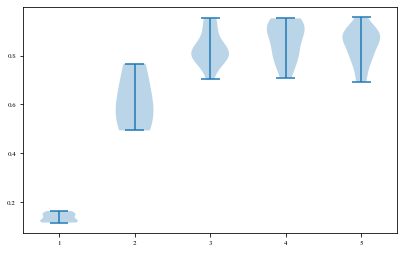

In [189]:
groups = [g.mcc for _, g in runs_df[[ "mcc", "gamma_square"]].groupby("gamma_square")]
plt.violinplot(groups)

{'bodies': [<matplotlib.collections.PolyCollection at 0x11e092730>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11e092670>,
 'cmins': <matplotlib.collections.LineCollection at 0x11e094e80>,
 'cbars': <matplotlib.collections.LineCollection at 0x11e0aa2b0>}

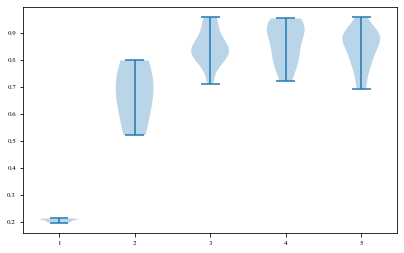

In [190]:
groups = [g.max_mcc for _, g in runs_df[[ "max_mcc", "gamma_square"]].groupby("gamma_square")]
plt.violinplot(groups)

In [23]:
#groups = [(np.abs(np.array(g.lhs-g.rhs))) for _, g in runs_df[[ *[col for col in runs_df.columns if "rhs" in col], *[col for col in runs_df.columns if "rhs" in col],  "gamma_square"]].groupby("gamma_square")]

In [178]:
df_rhs = pd.DataFrame(runs_df[[col for col in runs_df.columns if "rhs" in col]].stack().droplevel(1), columns=["rhs"])
df_lhs = pd.DataFrame(runs_df[[col for col in runs_df.columns if "sigma" in col]].stack().droplevel(1), columns=["lhs"])

KeyError: 'gamma_square'

In [179]:
df_rhs_lhs_gamma_sq = df_rhs.merge( df_lhs, left_index=True, right_index=True).merge(runs_df["gamma_square"], left_index=True, right_index=True)

{'bodies': [<matplotlib.collections.PolyCollection at 0x11f1978b0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11f1977c0>,
 'cmins': <matplotlib.collections.LineCollection at 0x11ddd8fa0>,
 'cbars': <matplotlib.collections.LineCollection at 0x11ddb43d0>}

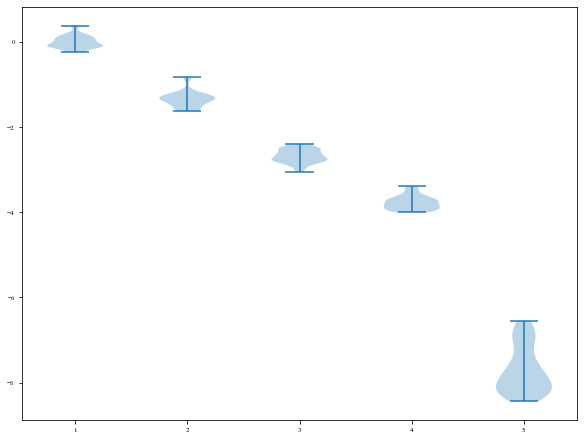

In [180]:
groups = [np.log10(g.lhs) for _, g in df_rhs_lhs_gamma_sq.groupby("gamma_square")]
plt.figure(figsize=(8,6))
plt.violinplot(groups)

{'bodies': [<matplotlib.collections.PolyCollection at 0x123ded100>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x121232430>,
 'cmins': <matplotlib.collections.LineCollection at 0x123df9730>,
 'cbars': <matplotlib.collections.LineCollection at 0x123df9b20>}

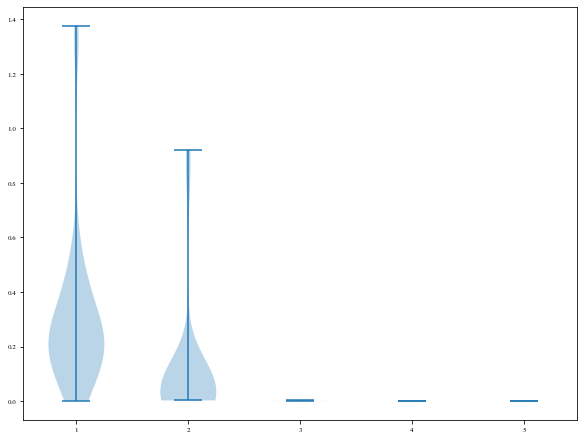

In [199]:
groups = [np.log10((g.lhs-g.rhs).abs()) for _, g in df_rhs_lhs_gamma_sq.groupby("gamma_square")]
plt.figure(figsize=(8,6))
plt.violinplot(groups)

{'bodies': [<matplotlib.collections.PolyCollection at 0x121792d00>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x120c71070>,
 'cmins': <matplotlib.collections.LineCollection at 0x11dc373d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x11dc377c0>}

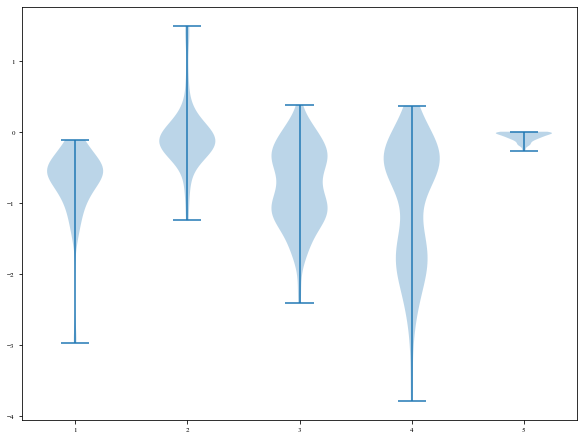

In [181]:
groups = [np.log10((g.lhs-g.rhs).abs()/g.lhs.abs()) for _, g in df_rhs_lhs_gamma_sq.groupby("gamma_square")]
plt.figure(figsize=(8,6))
plt.violinplot(groups)

{'bodies': [<matplotlib.collections.PolyCollection at 0x123e65a90>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x123e65970>,
 'cmins': <matplotlib.collections.LineCollection at 0x123e85130>,
 'cbars': <matplotlib.collections.LineCollection at 0x123e85520>}

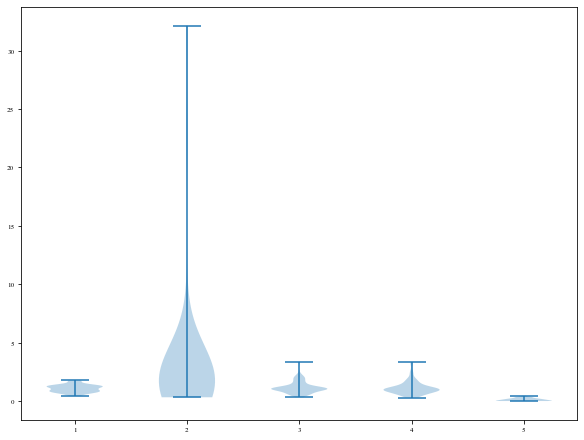

In [200]:
groups = [((g.rhs/g.lhs).abs()) for _, g in df_rhs_lhs_gamma_sq.groupby("gamma_square")]
plt.figure(figsize=(8,6))
plt.violinplot(groups)

{'bodies': [<matplotlib.collections.PolyCollection at 0x11dc650d0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11ddcd160>,
 'cmins': <matplotlib.collections.LineCollection at 0x11da5fd30>,
 'cbars': <matplotlib.collections.LineCollection at 0x11da4f160>}

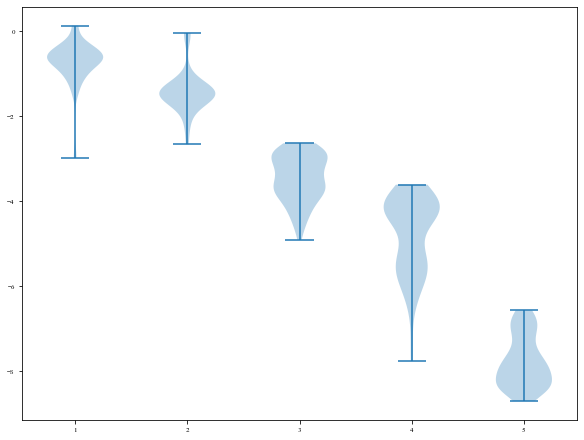

In [182]:
groups = [np.log10((g.lhs-g.rhs).abs()) for _, g in df_rhs_lhs_gamma_sq.groupby("gamma_square")]
plt.figure(figsize=(8,6))
plt.violinplot(groups)

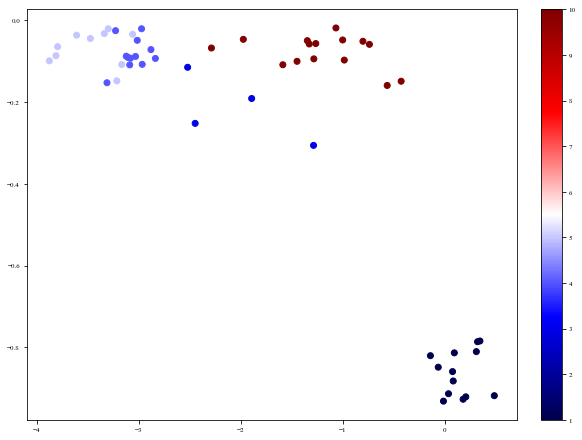

In [185]:
plt.figure(figsize=(8,6))
plt.scatter(np.log10(runs_df["cima"]), np.log10(runs_df[ "mcc"]), c=np.log10(runs_df["gamma_square"]), cmap="seismic")
plt.colorbar()

{'bodies': [<matplotlib.collections.PolyCollection at 0x11e0a8820>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x121474c10>,
 'cmins': <matplotlib.collections.LineCollection at 0x12145c280>,
 'cbars': <matplotlib.collections.LineCollection at 0x12145c670>}

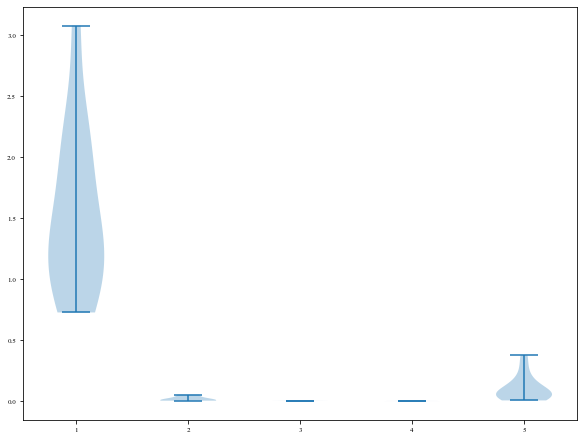

In [193]:
groups = [(g.cima) for _, g in runs_df[[ "cima", "gamma_square"]].groupby("gamma_square")]
plt.figure(figsize=(8,6))
plt.violinplot(groups)

{'bodies': [<matplotlib.collections.PolyCollection at 0x11e0ec9d0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11e0ec8e0>,
 'cmins': <matplotlib.collections.LineCollection at 0x11e0c9160>,
 'cbars': <matplotlib.collections.LineCollection at 0x11e0c94f0>}

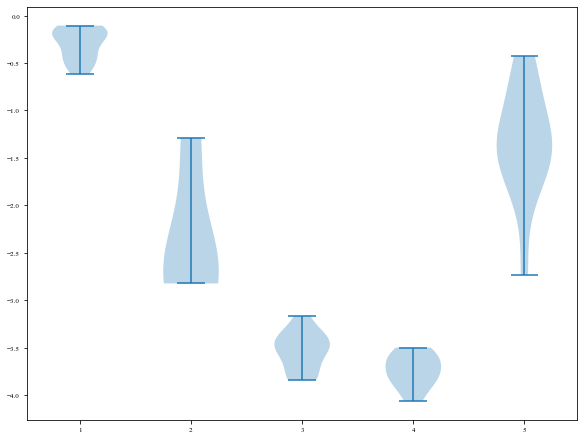

In [188]:
groups = [np.log10(g.min_cima) for _, g in runs_df[[ "min_cima", "gamma_square"]].groupby("gamma_square")]
plt.figure(figsize=(8,6))
plt.violinplot(groups)

{'bodies': [<matplotlib.collections.PolyCollection at 0x11f4e81c0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11f4b4e20>,
 'cmins': <matplotlib.collections.LineCollection at 0x11f4ea700>,
 'cbars': <matplotlib.collections.LineCollection at 0x11f4eaaf0>}

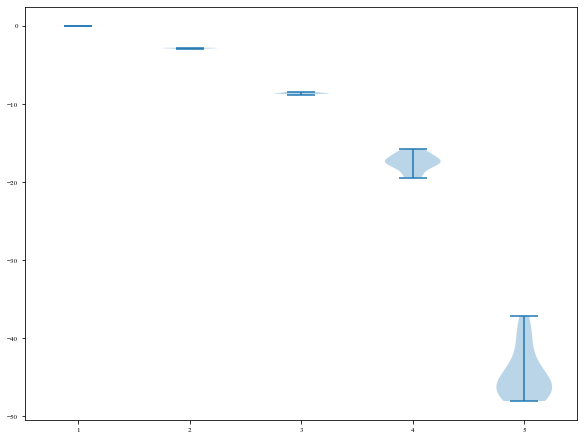

In [77]:
groups = [(g.kl_loss) for _, g in runs_df[[ "kl_loss", "gamma_square"]].groupby("gamma_square")]
plt.figure(figsize=(8,6))
plt.violinplot(groups)

{'bodies': [<matplotlib.collections.PolyCollection at 0x11fbf81c0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11fbf81f0>,
 'cmins': <matplotlib.collections.LineCollection at 0x11fc076a0>,
 'cbars': <matplotlib.collections.LineCollection at 0x11fc07a90>}

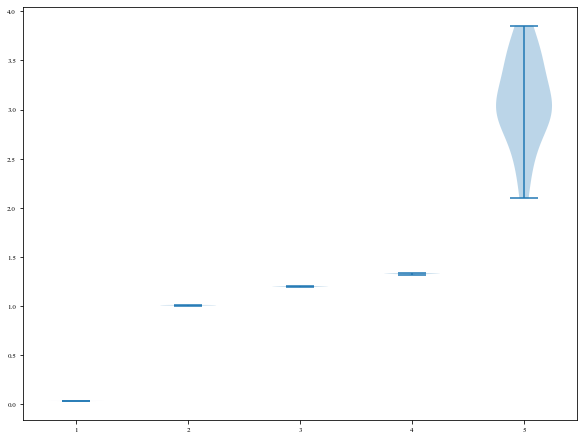

In [73]:
groups = [np.log10(g.rec_loss.abs()) for _, g in runs_df[[ "rec_loss", "gamma_square"]].groupby("gamma_square")]
plt.figure(figsize=(8,6))
plt.violinplot(groups)

{'bodies': [<matplotlib.collections.PolyCollection at 0x11f08d7f0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11f08d6d0>,
 'cmins': <matplotlib.collections.LineCollection at 0x11f09beb0>,
 'cbars': <matplotlib.collections.LineCollection at 0x11f0a92e0>}

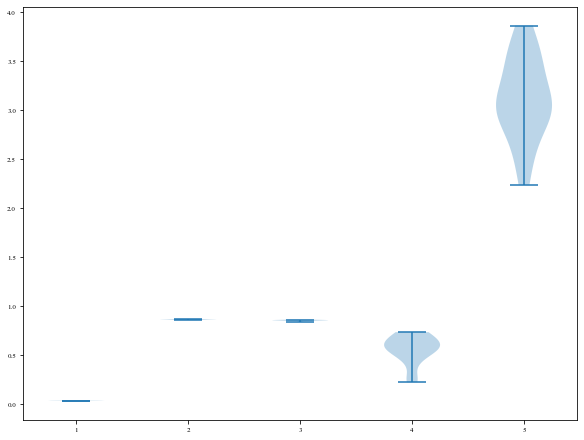

In [79]:
groups = [np.log10(g.neg_elbo.abs()) for _, g in runs_df[[ "neg_elbo", "gamma_square"]].groupby("gamma_square")]
plt.figure(figsize=(8,6))
plt.violinplot(groups)

In [25]:
ext_gamma_sq = [g*np.ones((d, 1)) for g,d in zip(gamma_sq, dim)]

In [26]:
def lhs_rhs(col_norm_squared, priors, variances, gamma_squared, ext_gamma_squared, prior_name):
    lhs = [s for s,p in zip(variances,priors) if p == prior_name]
    rhs = [1./(float(prior_name=="gaussian")+g_sq*J_sq) for g_sq, J_sq, p in zip(gamma_squared, col_norm_squared, priors) if p == prior_name]
    gamma = np.array([g for g,p in zip(gamma_squared, priors) if p == prior_name])
    gamma_ext = np.concatenate([g for g,p in zip(ext_gamma_squared, priors) if p == prior_name])

    abs_diff = np.abs(np.concatenate(lhs)-np.concatenate(rhs))
    lhs_rhs_vs_gamma =[ np.array([d for d, g in zip(abs_diff, gamma_ext) if g==gamma_select]) for gamma_select in np.unique(gamma_ext)  ]

    return lhs, rhs, gamma_ext, gamma, abs_diff, lhs_rhs_vs_gamma

In [47]:
lhs_gauss ,rhs_gauss,gamma_gauss_ext,  gamma_gauss, abs_diff_gauss, lhs_rhs_vs_gamma_gauss = lhs_rhs(col_norm_sq, prior, sigmas, gamma_sq, ext_gamma_sq, "gaussian")
lhs_laplace ,rhs_laplace,gamma_laplace_ext, gamma_laplace,  abs_diff_laplace, lhs_rhs_vs_gamma_laplace = lhs_rhs(col_norm_sq, prior, sigmas, gamma_sq,  ext_gamma_sq,"laplace")
lhs_uniform ,rhs_uniform,gamma_uniform_ext, gamma_uniform,  abs_diff_uniform, lhs_rhs_vs_gamma_uniform = lhs_rhs(col_norm_sq, prior, sigmas, gamma_sq,  ext_gamma_sq,"uniform")

In [48]:
def violin_by_prior(gauss_data, laplace_data, uniform_data, xticks, xlabel, ylabel,  offset, filename, figsize=(8,6), log=False):

    plt.figure(figsize=figsize)
    vp_gauss = plt.violinplot([np.log10(i) if log is True else i for i in gauss_data], positions=xticks)
    vp_laplace = plt.violinplot([np.log10(i) if log is True else i for i in laplace_data], positions=-offset+xticks)
    vp_uniform= plt.violinplot([np.log10(i) if log is True else i for i in uniform_data], positions=offset+xticks)
    plt.legend([vp_gauss['bodies'][0],vp_laplace['bodies'][0], vp_uniform['bodies'][0]], ['gaussian', 'laplace', 'uniform'], loc='upper right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(xticks)
    # plt.tight_layout()
    plt.savefig(filename)

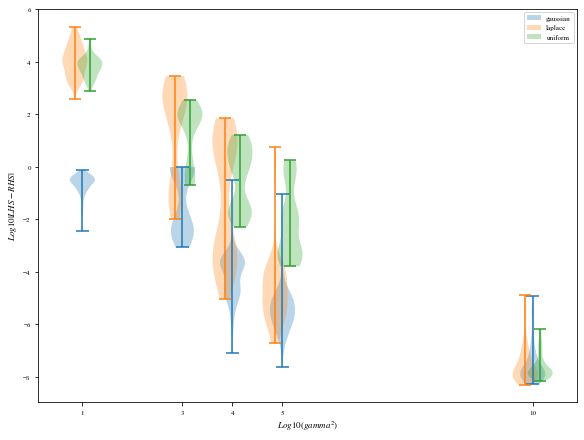

In [49]:
violin_by_prior(lhs_rhs_vs_gamma_gauss, lhs_rhs_vs_gamma_laplace, lhs_rhs_vs_gamma_uniform,  np.unique(np.log10(gamma_uniform_ext)), '$Log10(gamma^2)$', '$Log10|LHS-RHS|$',  0.15, 'opt_sigma_vs_gamma', log=True)

In [50]:
def cima_mcc(cimas, mccs, dims, priors,  prior_name):
    cima = np.array([c for c,p in zip(cimas, priors) if p == prior_name])
    mcc = np.array([m for m,p in zip(mccs, priors) if p == prior_name])
    dim = np.array([d for d,p in zip(dims, priors) if p == prior_name])


    cima_vs_dim = [ np.array([c for d, c in zip(dim, cima) if d==dim_select]) for dim_select in np.unique(dim)  ]
    mcc_vs_dim = [ np.array([m for d, m in zip(dim, mcc) if d==dim_select]) for dim_select in np.unique(dim)  ]

    return cima, mcc, dim, cima_vs_dim, mcc_vs_dim

In [51]:
cima_gauss, mcc_gauss, dim_gauss, cima_vs_dim_gauss, mcc_vs_dim_gauss = cima_mcc(cima, mcc, dim, prior, "gaussian")
cima_laplace, mcc_laplace, dim_laplace, cima_vs_dim_laplace, mcc_vs_dim_laplace = cima_mcc(cima, mcc, dim, prior, "laplace")
cima_uniform, mcc_uniform, dim_uniform, cima_vs_dim_uniform, mcc_vs_dim_uniform = cima_mcc(cima, mcc, dim, prior, "uniform")

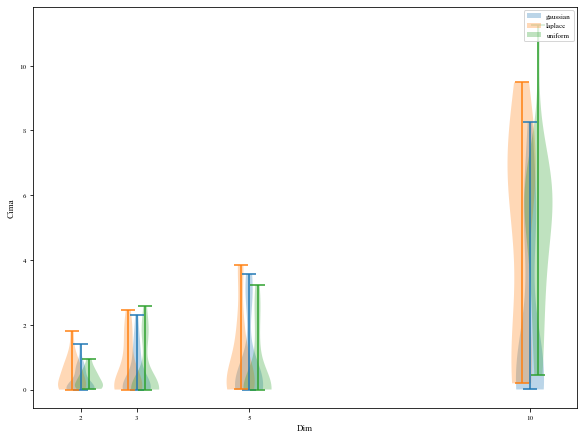

In [32]:
violin_by_prior(cima_vs_dim_gauss, cima_vs_dim_laplace, cima_vs_dim_uniform,  np.unique(dim), 'Dim', 'Cima',  0.15, 'cima_vs_dim')

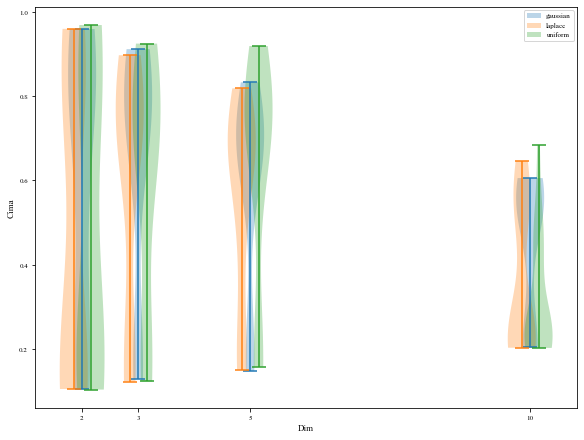

In [33]:
violin_by_prior(mcc_vs_dim_gauss, mcc_vs_dim_laplace, mcc_vs_dim_uniform,  np.unique(dim), 'Dim', 'Cima',  0.15, 'mcc_vs_dim')

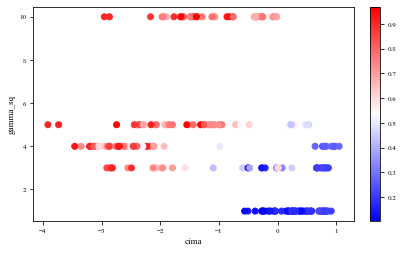

In [34]:
plt.scatter(np.log10(cima), np.log10(gamma_sq),c=mcc,cmap='bwr',)
plt.xlabel('cima')
plt.ylabel('gamma_sq')
plt.colorbar()

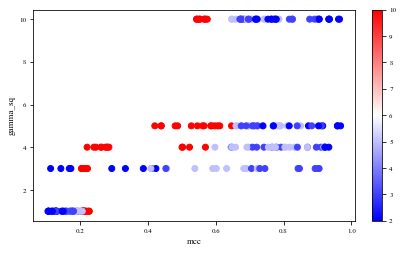

In [35]:
plt.scatter(mcc, np.log10(gamma_sq), c=dim,cmap='bwr',)
plt.xlabel('mcc')
plt.ylabel('gamma_sq')
plt.colorbar()

In [36]:
cima_vs_dim = [ np.array([c for d, c in zip(dim, cima) if d==dim_select]) for dim_select in np.unique(np.array(dim))  ]
mcc_vs_dim = [ np.array([m for d, m in zip(dim, mcc) if d==dim_select]) for dim_select in np.unique(np.array(dim))  ]

{'bodies': [<matplotlib.collections.PolyCollection at 0x1207d5a30>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x12076ec40>,
 'cmins': <matplotlib.collections.LineCollection at 0x124587eb0>,
 'cbars': <matplotlib.collections.LineCollection at 0x124587100>}

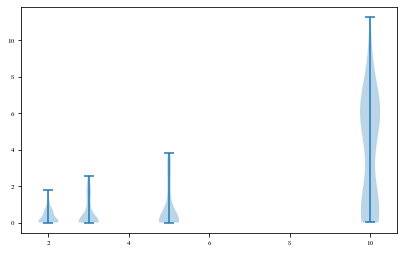

In [37]:
plt.violinplot(cima_vs_dim, positions=np.unique(np.array(dim)))

In [38]:
markers = ['o' if p=="gauss" else '^' if p=='laplace' else 's' for p in prior]

/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_55960/2388439361.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/rb/d8k1n6bj4lg801y0yxz4jtbh0000gn/T/ipykernel_55960/2388439361.py:9: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


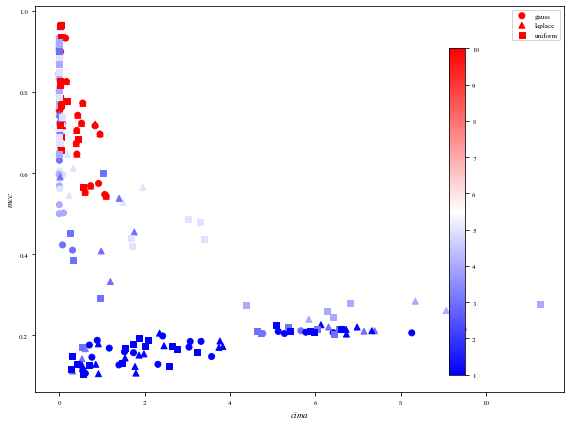

In [39]:
plt.figure(figsize=(8,6))
plt.scatter((cima_gauss),(mcc_gauss), c=np.log10(gamma_gauss),cmap='bwr', marker='o', label='gauss')
plt.scatter((cima_laplace),(mcc_laplace), c=np.log10(gamma_laplace),cmap='bwr', marker='^', label='laplace')
plt.scatter((cima_uniform),(mcc_uniform), c=np.log10(gamma_uniform),cmap='bwr', marker='s', label='uniform')
plt.xlabel("$cima$")
plt.ylabel("$mcc$")
plt.colorbar()
plt.legend()
plt.tight_layout()
plt.savefig('cima_vs_mcc')

In [58]:
gauss_mcc_vs_gamma = [ np.array([m,g]) for (g, m, d) in zip(gamma_gauss, mcc_gauss, dim_gauss) if d == 5]
gauss_mcc_vs_gamma_violin = [ np.array([m for m, g in gauss_mcc_vs_gamma if g==gamma_select]) for gamma_select in np.unique(gamma_gauss)  ]

In [60]:
np.unique(gamma_gauss)

array([1.e+01, 1.e+03, 1.e+04, 1.e+05, 1.e+10])

{'bodies': [<matplotlib.collections.PolyCollection at 0x126617d60>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x126617280>,
 'cmins': <matplotlib.collections.LineCollection at 0x126638b80>,
 'cbars': <matplotlib.collections.LineCollection at 0x1266179a0>}

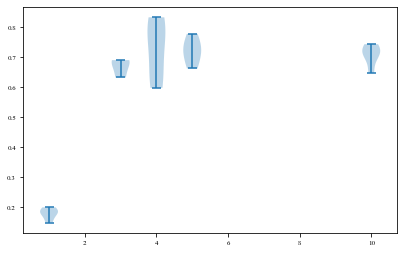

In [61]:
plt.violinplot(gauss_mcc_vs_gamma_violin, positions=np.log10(np.unique(gamma_gauss)))

In [62]:
gauss_cima_vs_gamma = [ np.array([m,g]) for (g, m, d) in zip(gamma_gauss, cima_gauss, dim_gauss) if d == 5]
gauss_cima_vs_gamma_violin = [ np.array([m for m, g in gauss_cima_vs_gamma if g==gamma_select]) for gamma_select in np.unique(gamma_gauss)  ]

{'bodies': [<matplotlib.collections.PolyCollection at 0x126615520>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x126615a60>,
 'cmins': <matplotlib.collections.LineCollection at 0x126626a00>,
 'cbars': <matplotlib.collections.LineCollection at 0x12662d5e0>}

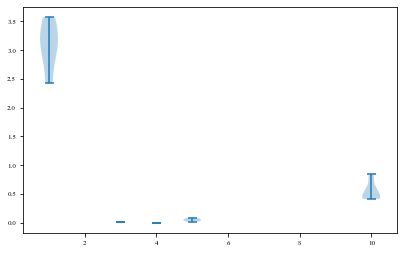

In [63]:
plt.violinplot(gauss_cima_vs_gamma_violin, positions=np.log10(np.unique(gamma_gauss)))